In [1]:
import ast
import os
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

import wordcloud as WordCloud

from recommendation_utils import *
from word_cloud import *

In [2]:
import importlib
import recommendation_utils
importlib.reload(recommendation_utils)
from recommendation_utils import *

In [3]:
# Read data
games = pd.read_csv("Data/games_detailed_info.csv", index_col=0) # review stats
n_rows, n_cols = games.shape

In [4]:
# 1. Remove columns with > 20% of NA values 
na_threshold = 0.2
key_columns = [colname for colname in games.columns if games[colname].isna().sum() <= na_threshold*n_rows]

print("Columns with > {}% of NA values: \n".format(na_threshold*100), set(games.columns)-set(key_columns))

Columns with > 20.0% of NA values: 
 {'Arcade Rank', 'boardgameexpansion', 'Customizable Rank', 'RPG Item Rank', 'Accessory Rank', 'Abstract Game Rank', 'Party Game Rank', 'Family Game Rank', 'War Game Rank', 'boardgameartist', 'boardgameintegration', 'Video Game Rank', 'Atari ST Rank', 'Strategy Game Rank', 'alternate', 'Thematic Rank', 'boardgameimplementation', 'Commodore 64 Rank', 'boardgamecompilation', "Children's Game Rank", 'Amiga Rank', 'boardgamefamily'}


In [5]:
# 2. Remove redundant/unnecesary columns
unnecessary_columns = ["type", "image", "suggested_num_players", "suggested_playerage", 
                       "suggested_language_dependence"]
readd_columns = ["boardgameexpansion"]
key_columns = [x for x in key_columns if x not in unnecessary_columns]
key_columns.extend(readd_columns)

In [6]:
# 3. Rename confusing column names
games = games.loc[:,key_columns]
games.rename(columns={"primary": "name", "usersrated": "numratings", "average": "avgrating",
                      "boardgamecategory": "category", "boardgamemechanic": "mechanic", 
                      "boardgamedesigner": "designer", "boardgamepublisher": "publisher", 
                      "bayesaverage": "bayesavgrating", "Board Game Rank": "rank", 
                      "stddev": "stdrating", "median": "medianrating",
                      "owned": "numowned", "trading": "numtrades", "wanting":"numwants", 
                      "wishing": "numwishes", "averageweight":"complexity"}, inplace=True)

In [7]:
# 4. Parse columns with list values
# Convert list of strings to list

for list_col in ["category", "mechanic", "designer", "publisher"]:
    games[list_col] = games[list_col].apply(lambda x: ast.literal_eval(x) if not(pd.isna(x)) else [])

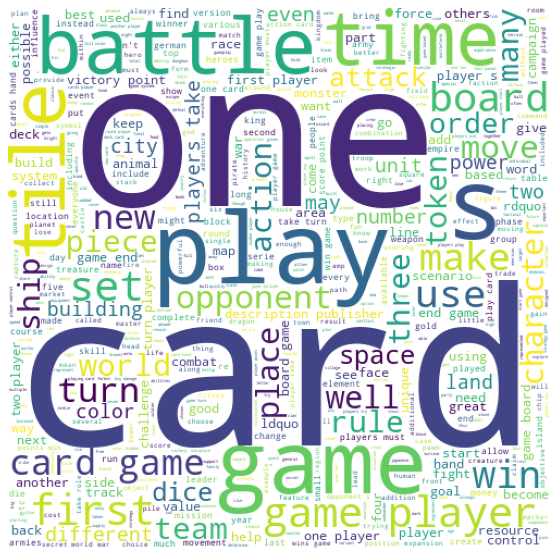

In [34]:
# Generate word cloud
generate_word_cloud(games['description'])

In [8]:
# 5. Keep top 10000 games and create encoded columns

top_10k_games = games[games['rank'] <= 10000].reset_index(drop=True)
# Encode multi-categorical columns
recommendation_df = top_10k_games.copy()
mechanic_encoding = add_encoded_column(recommendation_df, 'mechanic')
category_encoding = add_encoded_column(recommendation_df, 'category')
publisher_encoding = add_encoded_column(recommendation_df, 'publisher', 50, ['(Public Domain)', '(Unknown)', '(Web published)'])
designer_encoding = add_encoded_column(recommendation_df, 'designer', 20, ['(Uncredited)'])
# Generate counter columns
add_item_counts_column(recommendation_df, 'boardgameexpansion')

In [9]:
# 6. Generate similarity matrices using features of interest

similarity_cols = ['description'
                   , 'category_encoded'
                   , 'mechanic_encoded'
                   , 'publisher_encoded'
                   , 'designer_encoded'
                   , 'complexity'
                  ]

similarity_types = ['text'
                    , 'one_hot'
                    , 'one_hot'
                    , 'one_hot'
                    , 'one_hot'
                    , 'scalar'
                   ]

similarity_weights = [0.1, 0.25, 0.25, 0.1, 0.1, 0.2]

similarity_matrices = get_similarity_matrices(recommendation_df, similarity_cols, similarity_types)

In [10]:
# 7. Recommend games based on similarity scores

game_cb = widgets.Combobox(options=recommendation_df['name'].to_list(), description='Game')
@widgets.interact(name=game_cb)
def display_recommendations(name):
    try:
        return recommend_games(recommendation_df, [name], similarity_matrices, similarity_weights=similarity_weights, num_games=15)
    except AssertionError as e:
        return str(e)

interactive(children=(Combobox(value='', description='Game', options=('Pandemic', 'Carcassonne', 'Catan', '7 W…

In [11]:
games = ['Dominion', 'Scrabble', 'Wordsearch', 'Pandemic']
game_weights = [-0.75, 0.5, -0.25, 0.5]
exclude = ['Scarabeo']

recommend_games(recommendation_df, games, similarity_matrices,game_weights=game_weights, similarity_weights=similarity_weights, num_games=15, exclude=exclude)

['Pandemic: Hot Zone – North America',
 'Pandemic: Iberia',
 'Pandemic Legacy: Season 1',
 'Quarantine',
 'Upwords',
 'Pandemic: The Cure',
 'Pandemic Legacy: Season 2',
 'Super Scrabble',
 'Raxxon',
 'Healthy Heart Hospital',
 'Jarnac',
 'Pandemic: Reign of Cthulhu',
 'Mixmo',
 'Hospital Rush',
 'Word Domination']

In [12]:
# Read review data
reviews = pd.read_csv('Data/bgg-15m-reviews.csv', index_col=0)

C:\Users\shiva\.conda\envs\python37\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [13]:
# 8. Recommend games for a specific user
# use to find some usernames with x number orated games : reviews['user'].value_counts()[reviews['user'].value_counts() == 6]
# Some random usernames for testing: Gelband, Casanisl, Pakkman, jlobato, duska, jkoehler12, jeffhawke

user = 'Pakkman'
game_ratings = user_game_ratings(reviews, user)
games, ratings = zip(*game_ratings)
game_weights = rating_to_weights(ratings)
exclude = []

print('Played Games, Ratings: ', game_ratings)

suggested_games = recommend_games(recommendation_df, games, similarity_matrices,game_weights=game_weights, similarity_weights=similarity_weights, num_games=15, exclude=exclude)
print('Suggested Games: ', suggested_games)

Played Games, Ratings:  [['Colt Express', 8.5], ['7 Wonders', 10.0], ['Isle of Skye: From Chieftain to King', 10.0], ['Legends of Andor', 8.0], ['Zombicide Season 3: Rue Morgue', 9.0]]
Suggested Games:  ['7 Wonders Duel', 'Gran Circo', "It's a Wonderful World", 'Elasund: The First City', 'CIV: Carta Impera Victoria', 'Unfair', 'Johari', 'The Opulent', 'San Quentin Kings', 'Zombicide Season 2: Prison Outbreak', 'Oh My Goods!', 'Zombicide', 'Before the Wind', 'Jambo', 'Race for the Galaxy']
